#
# ------------------Zillow Project---------------------

## Objectives: 

## 1. Provide recommendations on how to build a better model to predict home value based on other recorded features of homes transacted in 2017. (Things that do and don't work.)

## 2. Determine the states and counties where the fips are located

## To be delivered to the Zillow Data Science team
#

## Project Plan:
## Follow the data science pipeline to find insights to present to the Zillow Data Science team on how to improve model performance to predict home values; identify the location of each transaction. Produce a GitHub repository and a final notebook from which to present findings.
#

# ----Setup----

In [1]:
# initial imports
from wrangle import acquire_zillow, wrangle_zillow, split_clean_zillow, x_y_split, identify_fips, scale_zillow, check_nulls_display_fips_df
from explore import stat_test_pearsons, homes_before_after_outliers
from model import build_regression_models, visualize_model_performance, evaluate_best_model, visualize_best_model

# Data manipulation and visualization utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#stats testing methods
from scipy.stats import pearsonr

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.metrics import explained_variance_score

import warnings

warnings.filterwarnings('ignore')

#
# ----Wrangle----

##
## Decisions made in wrangling:
## 1. the bathrooms feature was dropped due to multicolinearity with the bedrooms feature
## 2. homes with values above 1M were removed from the data set due to heteroskedasticity
##

In [24]:
# Wrangles the raw zillow data and loads it to a dataframe for visualizations
 
zillow_raw = wrangle_zillow_raw()

SyntaxError: unmatched ')' (2375459515.py, line 11)

In [5]:
# Bring in the zillow data using the wrangle module
zillow_df = wrangle_zillow()

The zillow data has been acquired, cleaned, and stored in the zillow_df dataframe


In [6]:
# Splits the data 60/20/20 into train, validate, and test
train, validate, test = split_clean_zillow(zillow_df)

train shape: (28080, 3)   -- 60.0% of zillow_df
validate shape: (9360, 3) -- 20.0% of zillow_df
test shape: (9361, 3)     -- 20.0% of zillow_df


In [7]:
# X-Y splits the data, also adds mean baseline column to y_train and y_validate
X_train, y_train, X_validate, y_validate, X_test, y_test = x_y_split(train, validate, test)

Train, validate, and test have been split into x_ and y_ dataframes. Mean baseline columns have been added to y_train and y_validate.


#
# ----Exploration----

# Initial questions:

## How do outliers effect this data set?
## Is square footage related to the target?
## Is bedroom count related to the target?

#

## Question: how do outliers in home value effect this data set?

## Graph One: 
## Heteroskedasticity in home values as seen on the raw data set

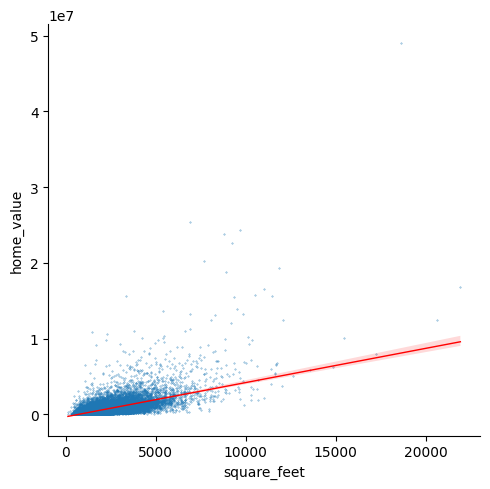

In [8]:
sns.lmplot(data=zillow_raw, x='square_feet', y='home_value', scatter_kws={'s': .1}, line_kws={'color':'red', 'linewidth':1});

## This distribution becomes much less tightly grouped as the home value increases, this suggests a linear regression model will do very poorly at predicting the target at more extreme models.
## A good strategy to handle this would be to first build a model that works on the majority of the data and then to develop another model or models to predict extreme target values (potentially a clustering model)


## Graph Two: 
## What the model sees before and after outliers are eliminated

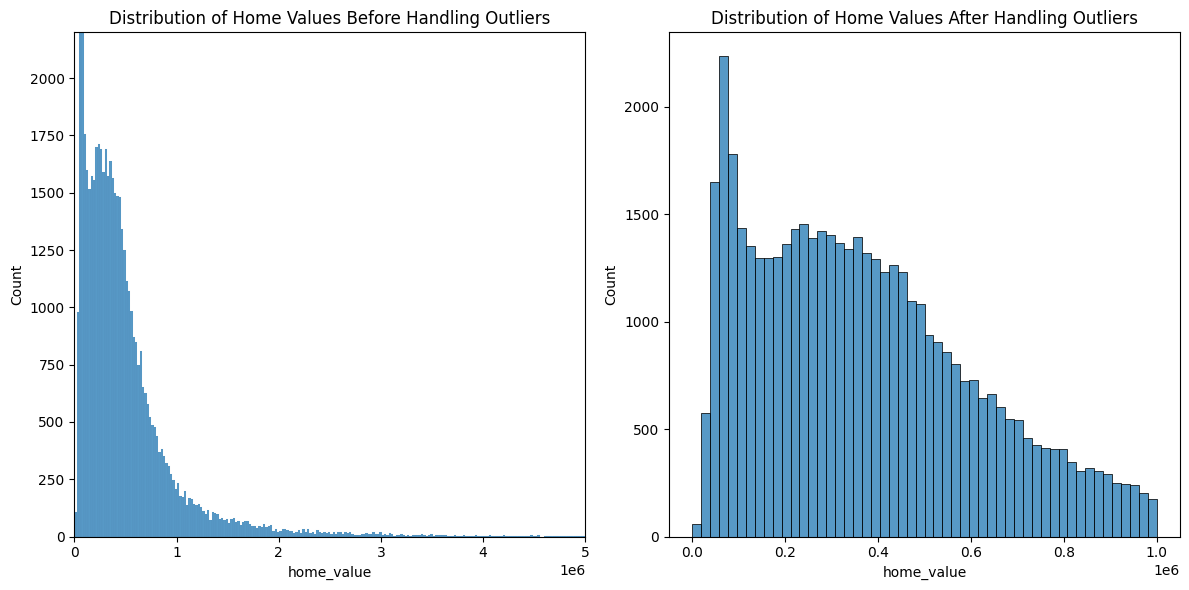

In [9]:
homes_before_after_outliers(zillow_raw, zillow_df)

## While I was going back and forth between modeling I first tried cutting off outliers at 1.5M, and saw a significant improvement in model performance. Then, I noticed that cutting off home values at 1M would only be a 10% loss of overall data, evaluated model performance on that basis, and discovered another massive leap in evaluation metrics.
## To further develop the model, it may be useful to trim outliers from other features as well

## Is bedroom count related to the target?¶

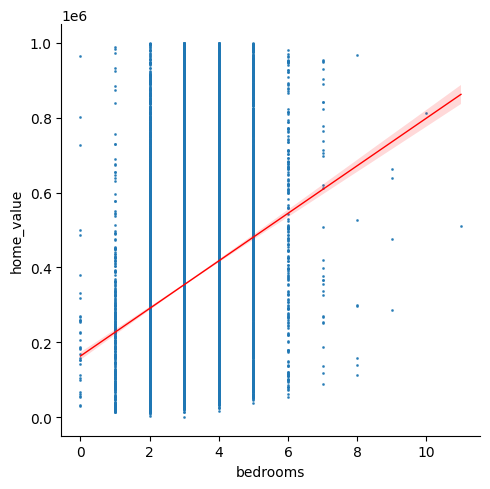

In [10]:
sns.lmplot(data=train, x='bedrooms', y='home_value', scatter_kws={'s': 1}, line_kws={'color':'red', 'linewidth':1});

In [11]:
# Run a stats test to determine if the relationship is significant
stat_test_pearsons(train, 'bedrooms', 'home_value')



Null hypothesis: There is no significant relationship between bedrooms and home_value

Alternative hypothesis: There is a significant relationship between bedrooms and home_value


----Results-----

R coefficient: 0.24 
P-value: 0.0

The p-value is less than the alpha. The relationship between bedrooms and home_value is significant



## Answer:  Yes, the relationship of bedroom count to the target is weak, but it is there and it is statistically significant

## Is square footage related to the target?

<function matplotlib.pyplot.show(close=None, block=None)>

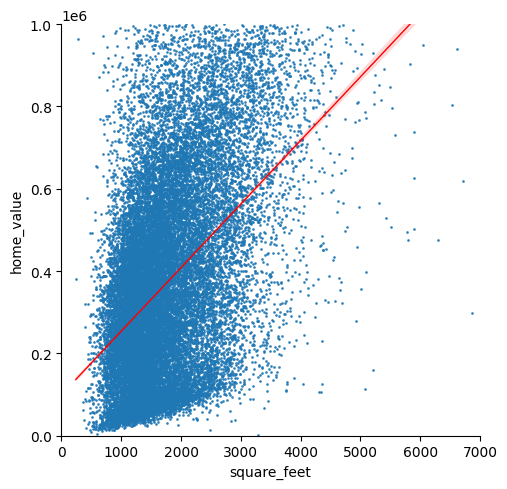

In [12]:
sns.lmplot(data=train, x='square_feet', y='home_value', scatter_kws={'s': 1}, line_kws={'color':'red', 'linewidth':1});
plt.xlim(0,7000)
plt.ylim(0,1000000)
plt.show


In [13]:
# Run a stats test to determine if the relationship is significant
stat_test_pearsons(train, 'square_feet', 'home_value')



Null hypothesis: There is no significant relationship between square_feet and home_value

Alternative hypothesis: There is a significant relationship between square_feet and home_value


----Results-----

R coefficient: 0.46 
P-value: 0.0

The p-value is less than the alpha. The relationship between square_feet and home_value is significant



## Answer: Yes, the relationship of square feet to home value is there, and it is statistically significant

## Exploration Findings:

## 1. The bedrooms relationship to home_value is extremely weak yet significant

## 2. Bedrooms and square_feet have some degree of multicolinearity, however there is high variance in the relationship so both features will still be taken to modeling

## 3. The square_feet relationship to home_value is very strong and significant

## 4. Cutting off home value outliers from the data set at 1M only reduces the total dataframe by 10% and significantly improves model performance

#
# --Modeling--
#
## With the selected features I will construct an array of models and evaluate their performance on the train and validate data:


In [14]:
# Scale the data using a MinMaxscaler
X_train, X_validate, X_test = scale_zillow(X_train, X_validate, X_test)

In [15]:
# Build a baseline model, an OLS model, and 5 LassoLars and 3 Polynomial models with varied hyperparameters
results_df, styled_df = build_regression_models(X_train, y_train, X_validate, y_validate)



10 regression models were successfully generated.
    
Yellow: the three models with the lowest train-validate difference (green may overlap with these and leave only two yellow rows);
Red: the baseline plus all models within one percent of the baseline rmse;
Green: either the model with the lowest train-validate difference or a model with a very low train-validate difference and the lowest validate rmse;


,model,rmse_train,rmse_validate,r_validate,model_difference
0,Mean Baseline,235901.400000,234884.000000,0.000000,1017.640000
1,OLS,208789.540000,207870.050000,0.220000,919.490000
2,LassoLars_a0.01,208788.060000,207884.910000,0.220000,903.157380
3,LassoLars_a0.02,208788.060000,207884.910000,0.220000,903.158734
4,LassoLars_a0.03,208788.060000,207884.900000,0.220000,903.160088
5,LassoLars_a0.04,208788.060000,207884.900000,0.220000,903.161442
6,LassoLars_a0.05,208788.060000,207884.900000,0.220000,903.162796
7,Polynomial_deg2,208329.190000,206904.010000,0.220000,1425.180000
8,Polynomial_deg3,208116.630000,206708.080000,0.230000,1408.550000
9,Polynomial_deg4,208054.860000,206568.790000,0.230000,1486.070000



Examine the above models and determine the best one for your purposes.
Generally, a green model will perform the best.



## LassoLars_a.01 seems to be the best option. I will verify this with a line graph of model performance.

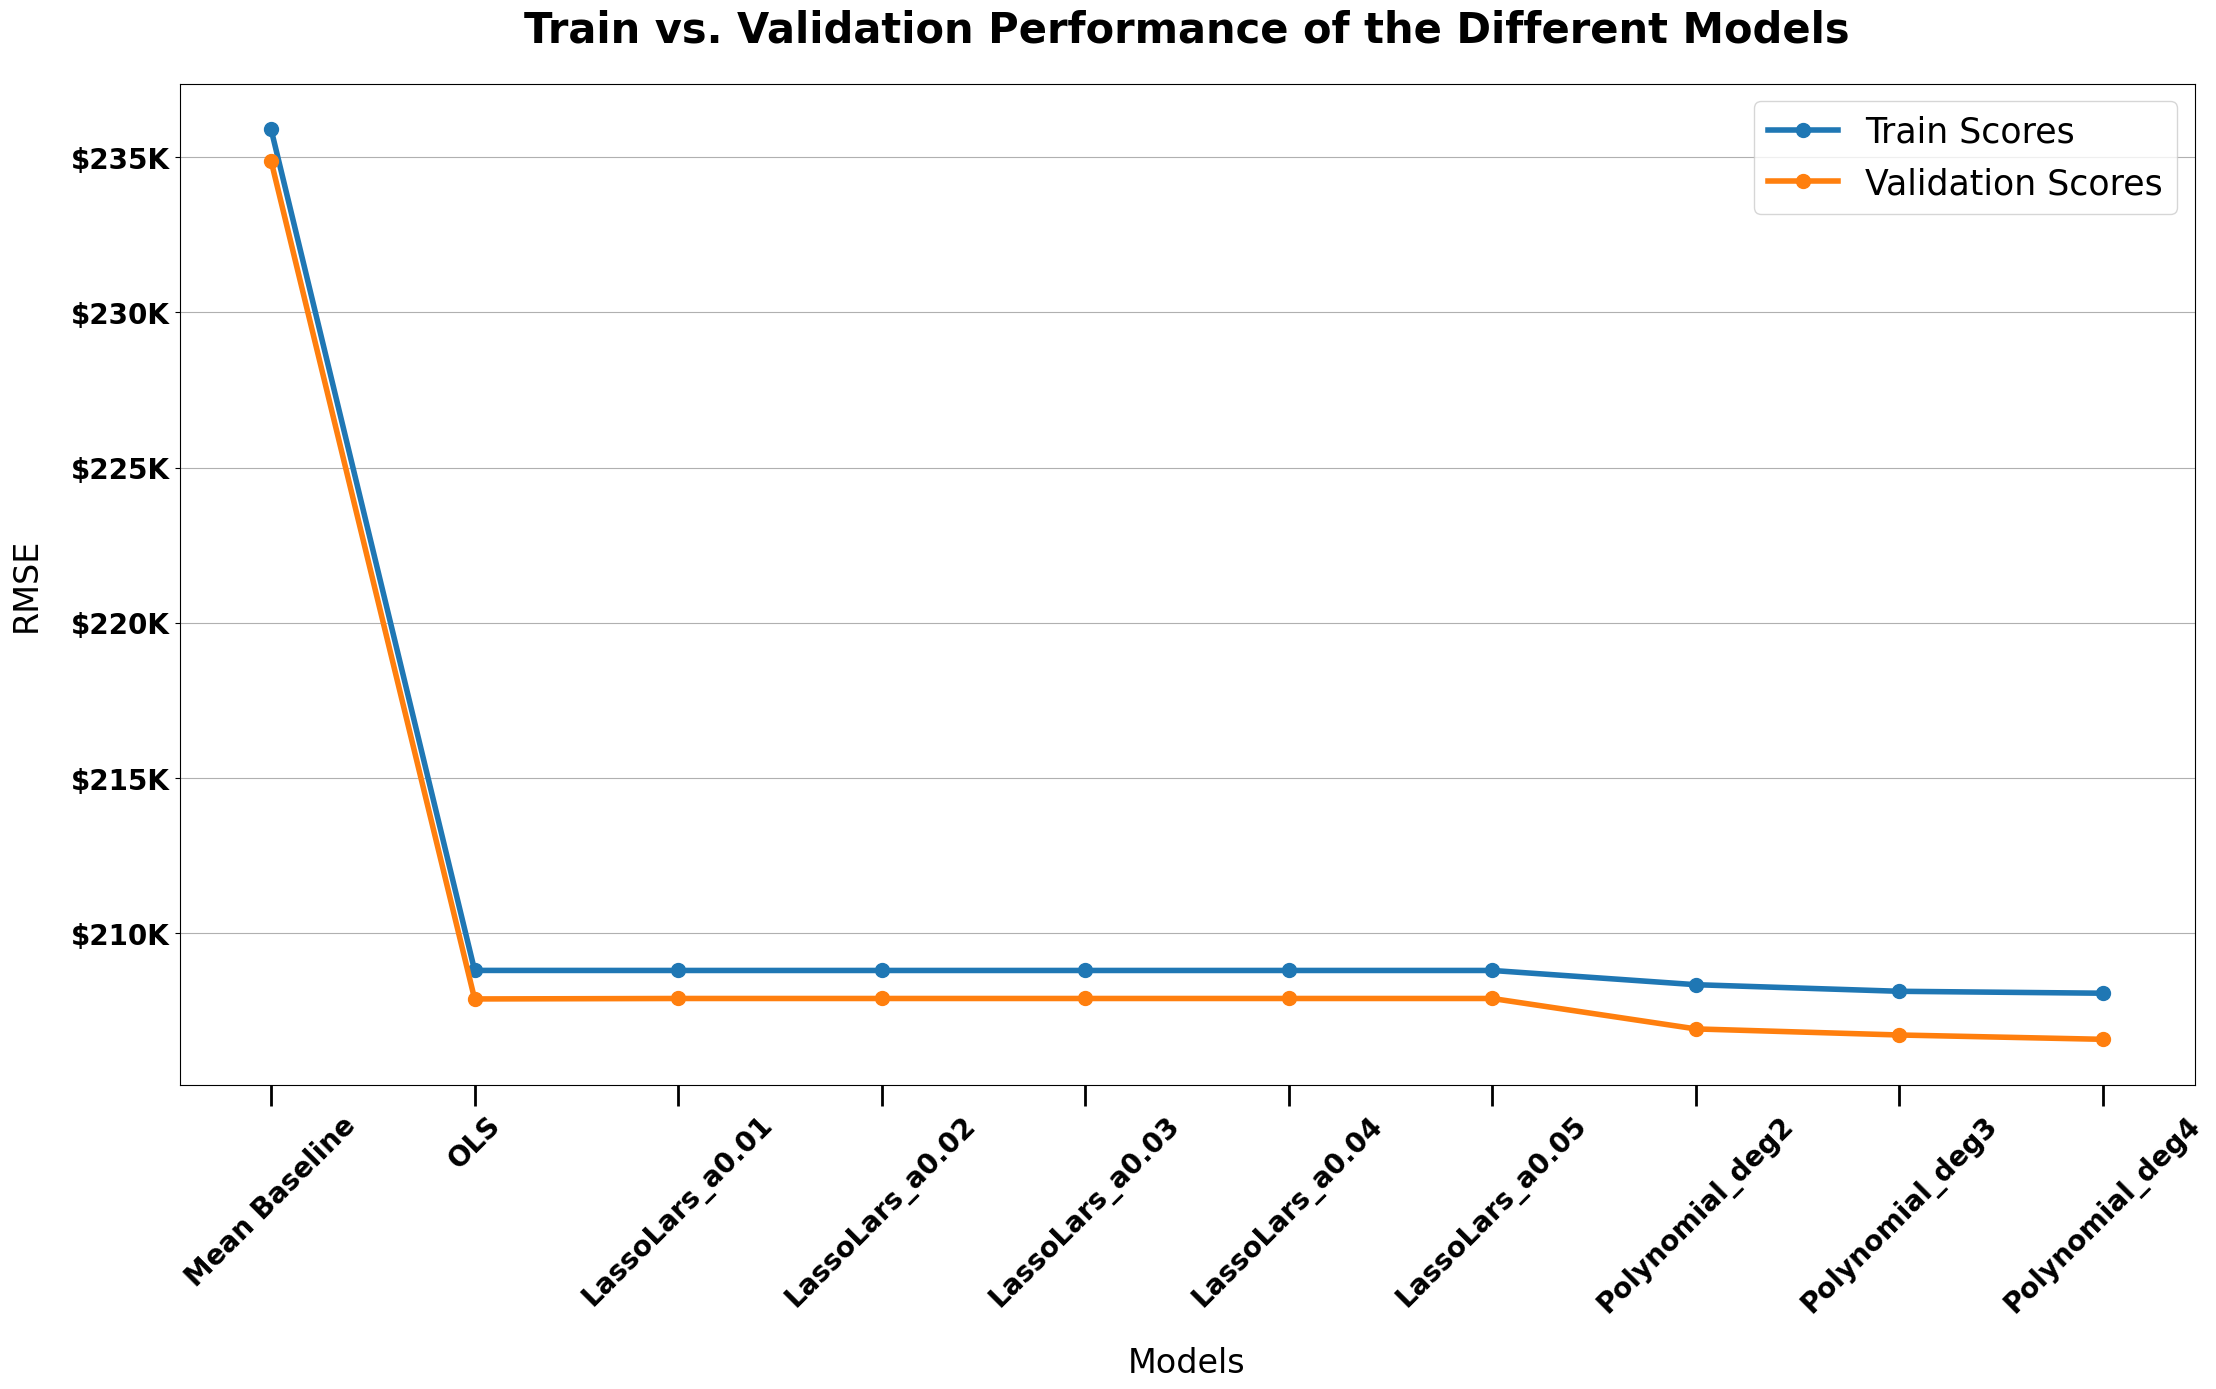

In [16]:
 visualize_model_performance(results_df)

####

## While the polynomial regression models perform with lower RMSE, the lasso models have tighter train-validate performance.
####
## The LassoLars_a.01 model is being selected to evaluate on test data.
#

## Evaluate the best model (LassoLars_a.01) on the test data set:

###

In [17]:
evaluate_best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)


Model performace:


,rmse_train,rmse_validate,rmse_test,r_test,model_difference
model,,,,,
LassoLars_a0.01,208788.06,207884.91,207884.91,0.22,877.13


#

## The model performs at 207884 RMSE and .22 R_2

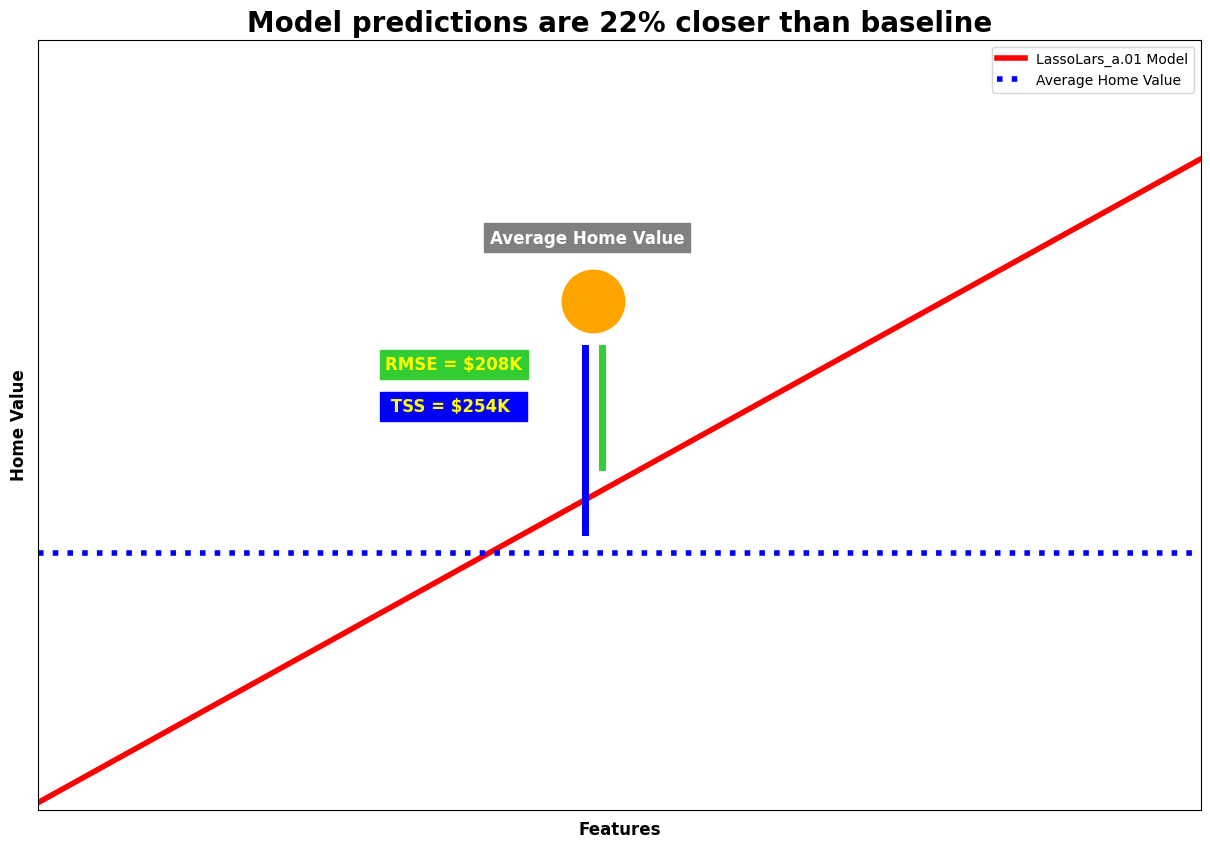

<Figure size 4000x2000 with 0 Axes>

In [18]:
visualize_best_model()

#
# ----State and County Data----
#
## Add state and county data to the original dataframe of 2017 transactions:
## To identify the location of each of the transaction listings, I found a data set which links fips codes to their state and county information and merged it onto the IDs of each home in the original data set that was purchased in 2017
## The link to the fips data set can be found here: [Link to fips data source](https://github.com/kjhealy/us-county/blob/master/data/census/fips-by-state.csv)
#

In [19]:
# Load the csv file containing the fips, state, and county data and read it into a dataframe
fips_df = identify_fips()

In [20]:
# Display the dataframe
   
check_nulls_display_fips_df(fips_df)


Count of all nulls in the dataframe by column:


id        0
fips      0
county    0
state     0
dtype: int64


No nulls were found.

This is a truncated display of the transaction id dataframe with state and county info matched by fips code:


,id,fips,county,state
0,1727539,6059.0,Orange County,CA
1,1387261,6111.0,Ventura County,CA
2,11677,6059.0,Orange County,CA
3,2288172,6037.0,Los Angeles County,CA
4,781532,6037.0,Los Angeles County,CA
...,...,...,...,...
52437,673515,6037.0,Los Angeles County,CA
52438,2968375,6111.0,Ventura County,CA
52439,1843709,6037.0,Los Angeles County,CA
52440,1187175,6037.0,Los Angeles County,CA


## Note that there are no nulls, and that the resulting dataframe is the same length as the original dataframe of 2017 transactions so we can be confident that every fips code was matched and joined properly to the state and county information.

#
# ----Conclusions----
## The project objectives were met: recommendations to build a better model were presented and state and county information were matched and added to the list of 2017 home transactions. 
##
# ----Recommendations----
## Merging the bedrooms and bathrooms information into a ratio does not add value to a model because it increases feature variance when plotted against home_value. Do not combine these features in future models.
## Eliminating outliers in the home value distribution will increase model performance. Only 10% of the transactions are above 1M, eliminating these from the data set reduces heteroskedasticity and dramatically improves model performance
## The dataframe I was able to create which matches state and county information to each transaction id may be added to the Zillow database server, possibly using transaction 'id' as the primary key and 'fips' as a foreign key
##
# ----Next steps----
## To further improve model performance, feature selection methods may be used to determine other columns in the data that can add predictive power to future models
## It may be useful to experiment with trimming outlier values from other model features as well, besides just the home value
## If desirable to the Zillow Data Science team, develop a model that works well at predicting extreme target values (potentially a clustering model)
#